# 151 Trading Strategies -  4.4 Mean-reversion

#### Data used for this notebook:

1. [S&P 500 Stocks (daily updated)](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_stocks.csv)

# The strategy: 

<img src="https://raw.githubusercontent.com/xxxxyyyy80008/financial-machine-learning/main/151_Trading_Strategies/img/151_4_4_mean_reversion.png" width="700">



# Reference:

>  Kakushadze, Zura and Serur, Juan Andrés, 151 Trading Strategies (August 17, 2018). Z. Kakushadze and J.A. Serur. 151 Trading Strategies. Cham, Switzerland: Palgrave Macmillan, an imprint of Springer Nature, 1st Edition (2018), XX, 480 pp; ISBN 978-3-030-02791-9, Available at SSRN: https://ssrn.com/abstract=3247865



In [1]:
import pandas as pd
import numpy as np
import os
import gc
import copy
from pathlib import Path
from datetime import datetime, timedelta, date
import time
from dateutil.relativedelta import relativedelta 

import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm
import seaborn as sns

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1
pl.seed_everything(random_seed)

1

In [3]:
sp500 = pd.read_csv("../input/sp-500-stocks/sp500_stocks.csv")

In [4]:
sp500['Date'] = sp500['Date'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))

In [5]:
sp500.head(2)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,59.32,83.02,83.45,82.67,83.09,"3,043,700.00"
1,2010-01-05,MMM,58.95,82.50,83.23,81.70,82.80,"2,847,000.00"


In [6]:
pd.pivot_table(sp500, index='Symbol', values=['Date'], aggfunc=[np.min, np.max])

,amin,amax
,Date,Date
Symbol,,
A,2010-01-04,2022-10-07
AAL,2010-01-04,2022-10-07
AAP,2010-01-04,2022-10-07
AAPL,2010-01-04,2022-10-07
ABBV,2010-01-04,2022-10-07
...,...,...
YUM,2010-01-04,2022-10-07
ZBH,2010-01-04,2022-10-07


# Calculate IBS (Internal Bar Strength)

In [7]:
sp500['ibs'] = (sp500['Close'] - sp500['Low'])/(sp500['High'] - sp500['Low'])

In [8]:
p_ibs = pd.pivot_table(sp500, index='Symbol', values=['ibs'], aggfunc=[np.min, np.max, np.mean])

In [9]:
def hist(data, name, bins=50):
    #plt.rcParams['figure.dpi'] = 227
    plt.figure(figsize=(6,4))
    plt.style.use('seaborn-whitegrid')
    plt.hist(data, bins=bins, facecolor='lightseagreen', alpha=0.6)
    plt.title(name, fontsize=9)
    plt.axvline(np.array(data.mean()), color='tomato', ls='--', lw=2)
    plt.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='--', linewidth=0.5)
    plt.xlabel(data.name, fontsize=10)
    plt.ylabel('count', fontsize=10)
    plt.show() 

In [10]:
def multi_hist(datas, captions, bins=None, figsize=(13, 4), sharey=False):
    ncols = len(datas)
    fig, axs = plt.subplots(1, ncols, figsize=figsize, sharey=sharey)
    plt.style.use('seaborn-whitegrid')
    
    if bins is None:
        bins=[50]*len(datas)
    
    for i, data in enumerate(datas):
        if data.index.dtype in ['int64', 'int32', 'float64', 'float32']:
            data.index = data.index.astype(str)
            
#         axs[i].bar(data.index.values, data.values, color="lightseagreen", width=.5, alpha=0.8)
        axs[i].hist(data, bins=bins[i], facecolor='lightseagreen', alpha=0.7)
        axs[i].axvline(np.array(data.mean()), color='tomato', ls='--', lw=2)
        axs[i].grid(visible=True, which='major', axis='both', color='lightgray', linestyle='-', linewidth=0.2)
        axs[i].spines[['top', 'right']].set_visible(False)
        axs[i].spines[['bottom', 'left']].set_edgecolor('whitesmoke')

        #axs[i].set_ylabel(data.name)
        axs[i].set_title(captions[i], fontsize=13, loc='left')

    
#     plt.suptitle('')
    plt.show()  

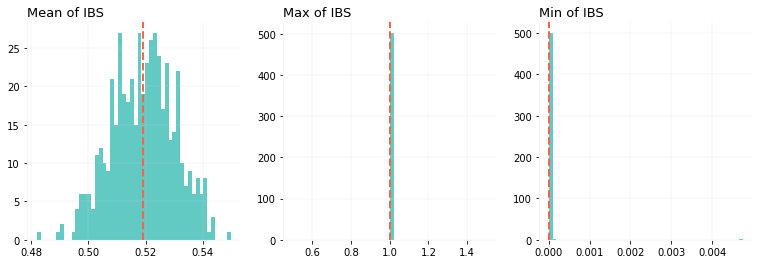

In [11]:
datas = [p_ibs[('mean', 'ibs')], p_ibs[('amax', 'ibs')], p_ibs[('amin', 'ibs')],]
captions = ['Mean of IBS', 'Max of IBS', 'Min of IBS']

multi_hist(datas, captions, bins=None, figsize=(13, 4), sharey=False)

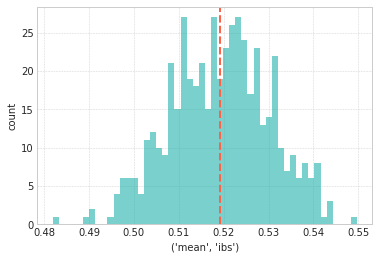

In [12]:
hist(p_ibs[('mean', 'ibs')], '')

# Trade: Buy bottom 10 and Sell top 10 by previous day IBS

### For each day:


- Rank stocks by previous day IBS
- Buy bottom 10 (10 with smallest IBS values)
- Sell top 10 (10 with largest IBS values)
- Enter trade on `Adj Close` price and Exit trade the next day on `Adj Close` price


In [13]:
#get previous day ibs for each stock
sp500['pre_ibs']=sp500[['Symbol', 'ibs']].groupby('Symbol').shift(1)

In [14]:
#drop rows with missing values
sp500.dropna(how='any', subset=['pre_ibs'], inplace=True)

In [15]:
sp500[sp500['Symbol']=='A']

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,ibs,pre_ibs
41848,2010-01-05,A,20.21,22.15,22.33,22.00,22.32,"4,186,031.00",0.43,0.34
41849,2010-01-06,A,20.14,22.07,22.17,22.00,22.07,"3,243,779.00",0.38,0.43
41850,2010-01-07,A,20.12,22.04,22.05,21.82,22.02,"3,095,172.00",0.97,0.38
41851,2010-01-08,A,20.11,22.03,22.07,21.75,21.92,"3,733,918.00",0.89,0.97
41852,2010-01-11,A,20.12,22.05,22.21,21.94,22.09,"4,781,579.00",0.39,0.89
...,...,...,...,...,...,...,...,...,...,...
45061,2022-10-03,A,126.38,126.38,127.30,121.68,122.73,"1,343,200.00",0.84,0.05
45062,2022-10-04,A,131.41,131.41,131.56,128.57,128.79,"1,647,800.00",0.95,0.84
45063,2022-10-05,A,132.64,132.64,133.53,129.50,129.99,"1,567,700.00",0.78,0.95
45064,2022-10-06,A,132.18,132.18,133.82,131.60,132.30,"1,218,400.00",0.26,0.78


In [16]:
#rank by previous day ibs values in ascending order
sp500['pre_ibs_rank'] = sp500[['Date', 'pre_ibs']].groupby('Date').rank(ascending=True, method='first', na_option='bottom')

#rank by previous day ibs values in descending order
sp500['pre_ibs_rank_reverse'] = sp500[['Date', 'pre_ibs']].groupby('Date').rank(ascending=False, method='first', na_option='bottom')

In [17]:
#Buy bottom 10 (10 with smallest IBS values)
#Sell top 10 (10 with largest IBS values)
sp500['Buy'] = sp500['pre_ibs_rank']<=10
sp500['Sell'] = sp500['pre_ibs_rank_reverse']<=10

In [18]:
sp500[sp500['Date']=='2022-10-06'].sort_values(by='pre_ibs')

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,ibs,pre_ibs,pre_ibs_rank,pre_ibs_rank_reverse,Buy,Sell
48283,2022-10-06,APD,238.59,238.59,242.76,237.89,241.17,"965,400.00",0.14,0.04,1.00,503.00,True,False
460315,2022-10-06,DE,355.47,355.47,359.34,353.04,354.24,"915,100.00",0.39,0.11,2.00,502.00,True,False
898099,2022-10-06,LHX,220.50,220.50,222.49,219.92,220.00,"990,600.00",0.23,0.11,3.00,501.00,True,False
1554775,2022-10-06,WM,159.40,159.40,165.75,158.88,165.13,"3,010,400.00",0.08,0.11,4.00,500.00,True,False
762901,2022-10-06,HRL,44.91,44.91,46.20,44.85,46.16,"2,337,700.00",0.04,0.12,5.00,499.00,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569761,2022-10-06,EQT,43.94,43.94,45.91,43.75,45.05,"5,541,500.00",0.09,0.92,499.00,5.00,False,True
798310,2022-10-06,ILMN,212.72,212.72,219.60,210.53,216.59,"1,553,000.00",0.24,0.93,500.00,4.00,False,True
173824,2022-10-06,ADSK,205.87,205.87,209.64,203.37,203.81,"1,791,600.00",0.40,0.94,501.00,3.00,False,True
766120,2022-10-06,HST,16.56,16.56,16.97,16.48,16.65,"6,926,100.00",0.16,0.95,502.00,2.00,False,True


In [19]:
# calculate the return for each potential trade
sp500['Next_AdjClose']=sp500[['Symbol', 'Adj Close']].groupby('Symbol').shift(-1)

In [20]:
sp500['Target']=(sp500['Next_AdjClose']-sp500['Adj Close'])/sp500['Adj Close']

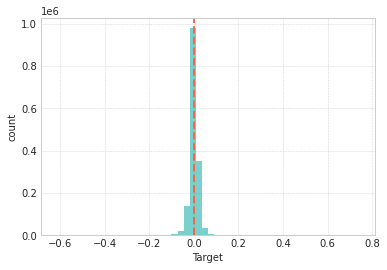

In [21]:
hist(sp500['Target'], '')

In [22]:
#calculate the sharpe ratio
#https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition
import numpy as np
import pandas as pd


def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [23]:
sp500['Rank']=np.int64(sp500['pre_ibs_rank'].values-1)
for p, t in [[10, 2], [20, 2], [25, 1], [50,2]]:
    sharpe = calc_spread_return_sharpe(df=sp500, portfolio_size = p, toprank_weight_ratio = t)
    print(p, t, sharpe)

10 2 -0.0008303916297416351
20 2 0.0073458969224720035
25 1 0.010848668708617793
50 2 0.0107633453748633


In [24]:
sp500['Rank']=np.int64(sp500['pre_ibs_rank_reverse'].values-1)
for p, t in [[10, 2], [20, 2], [25, 1], [50, 2]]:
    sharpe = calc_spread_return_sharpe(df=sp500, portfolio_size = p, toprank_weight_ratio = t)
    print(p, t, sharpe)

10 2 0.006925449925793309
20 2 -0.005511126641207414
25 1 -0.01133742010272558
50 2 -0.009383812211712814


# Trade performance summary

Trade setup:

- Initial amount (principal) for each trade: max at 10000 USD
- Minimal shares: 10 shares



In [25]:
max_init_amount = 10000 #this is a soft cap, each trade must have at least 10 shares
min_shares = 10
def cal_shares(price):
    shares = min_shares
    if (price is np.nan) | (price is None):
        shares = 0
    elif (max_init_amount/price)>min_shares:
        shares = int(max_init_amount/price)
        
    return  shares 
        

In [26]:
sp500['shares'] = sp500.apply(lambda x: cal_shares(x['Adj Close']) , axis=1)
sp500.loc[(sp500['Buy']==False) & (sp500['Sell']==False), 'shares'] = 0
sp500['init_amount'] = sp500['shares'] * sp500['Adj Close']
sp500['end_amount'] = sp500['shares'] * sp500['Next_AdjClose']
sp500['cost'] = sp500['init_amount']*0.003

sp500['pnl'] = sp500['end_amount'] - sp500['init_amount']
sp500.loc[sp500['Buy'], 'pnl'] = sp500.loc[sp500['Buy'], 'pnl'] - sp500.loc[sp500['Buy'], 'cost']
sp500.loc[sp500['Sell'], 'pnl'] = -sp500.loc[sp500['Sell'], 'pnl'] - sp500.loc[sp500['Sell'], 'cost']

In [27]:
sp500[sp500['Date']=='2022-10-06'].sort_values(by='pre_ibs')

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,ibs,pre_ibs,pre_ibs_rank,pre_ibs_rank_reverse,Buy,Sell,Next_AdjClose,Target,Rank,shares,init_amount,end_amount,cost,pnl
48283,2022-10-06,APD,238.59,238.59,242.76,237.89,241.17,"965,400.00",0.14,0.04,1.00,503.00,True,False,231.75,-0.03,502,41,"9,782.19","9,501.75",29.35,-309.79
460315,2022-10-06,DE,355.47,355.47,359.34,353.04,354.24,"915,100.00",0.39,0.11,2.00,502.00,True,False,356.15,0.00,501,28,"9,953.16","9,972.20",29.86,-10.82
898099,2022-10-06,LHX,220.50,220.50,222.49,219.92,220.00,"990,600.00",0.23,0.11,3.00,501.00,True,False,224.32,0.02,500,45,"9,922.50","10,094.40",29.77,142.13
1554775,2022-10-06,WM,159.40,159.40,165.75,158.88,165.13,"3,010,400.00",0.08,0.11,4.00,500.00,True,False,155.24,-0.03,499,62,"9,882.80","9,624.88",29.65,-287.57
762901,2022-10-06,HRL,44.91,44.91,46.20,44.85,46.16,"2,337,700.00",0.04,0.12,5.00,499.00,True,False,44.54,-0.01,498,222,"9,970.02","9,887.88",29.91,-112.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569761,2022-10-06,EQT,43.94,43.94,45.91,43.75,45.05,"5,541,500.00",0.09,0.92,499.00,5.00,False,True,43.17,-0.02,4,227,"9,974.38","9,799.59",29.92,144.87
798310,2022-10-06,ILMN,212.72,212.72,219.60,210.53,216.59,"1,553,000.00",0.24,0.93,500.00,4.00,False,True,206.18,-0.03,3,47,"9,997.84","9,690.46",29.99,277.39
173824,2022-10-06,ADSK,205.87,205.87,209.64,203.37,203.81,"1,791,600.00",0.40,0.94,501.00,3.00,False,True,194.74,-0.05,2,48,"9,881.76","9,347.52",29.65,504.59
766120,2022-10-06,HST,16.56,16.56,16.97,16.48,16.65,"6,926,100.00",0.16,0.95,502.00,2.00,False,True,16.30,-0.02,1,603,"9,985.68","9,828.90",29.96,126.82


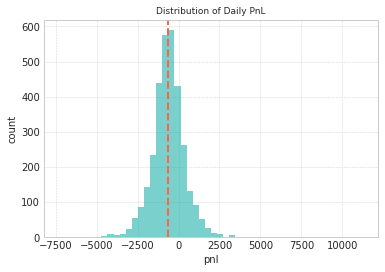

In [28]:
hist(sp500[['Date', 'pnl']].groupby('Date')['pnl'].sum(), 'Distribution of Daily PnL')

In [29]:
sp500[['Date', 'pnl']].groupby('Date')['pnl'].sum().describe()

count    3,213.00
mean      -612.14
std      1,066.00
min     -7,311.98
25%     -1,149.55
50%       -609.02
75%        -66.19
max     11,275.76
Name: pnl, dtype: float64

In [30]:
sp500['pnl'].sum()

-1966820.1249256593